# 데이터 취득

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]
df

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


# 데이터 전처리

### 학습용 데이터 Q_input, A_input, A_target 생성

In [3]:
Q_inputs = []
A_inputs = []
A_targets = []

In [4]:
for line in df['Q']:
        
        Q = line.split('\t')
        
        Q_inputs.append(Q)

In [5]:
len(Q_inputs)

11823

In [6]:
print(Q_inputs[0])

['12시 땡!']


In [7]:
for line in df['A']:

        A = line.split('\t')
        
        
        A_input = '<bos> ' + A[0]
        A_target = A[0] + ' <eos>'

        A_inputs.append(A_input)
        A_targets.append(A_target)

In [8]:
len(A_inputs), len(A_targets)

(11823, 11823)

In [9]:
print(A_inputs[0],A_targets[0])

<bos> 하루가 또 가네요. 하루가 또 가네요. <eos>


In [10]:
VOCAB_SIZE = 11823

### 토커나이저 학습(sentencepiece 활용)

- 접두사, 접미사 처리 (bos, eos)

In [11]:
import math
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Okt

okt = Okt()

def _flatten_iter(x):
    # 중첩 리스트까지 안전하게 평탄화
    from collections.abc import Iterable
    for el in x:
        if isinstance(el, (list, tuple)):
            yield from _flatten_iter(el)
        else:
            yield el

def to_text(x):
    """모든 입력을 문자열로 정규화"""
    # NaN/None 처리
    try:
        if x is None or (isinstance(x, float) and math.isnan(x)):
            return ""
    except Exception:
        pass

    # 이미 문자열
    if isinstance(x, str):
        return x

    # 리스트/튜플(중첩 포함) → 공백으로 연결
    if isinstance(x, (list, tuple)):
        return " ".join(map(str, _flatten_iter(x)))

    # 그 외 타입은 문자열로
    return str(x)

# 1) 원소들을 문자열로 정규화
Q_inputs_text = [to_text(x).strip() for x in Q_inputs]

# 2) 형태소 분석 (조사/어미까지 쪼개고 싶다면 stem/norm 옵션 조정)
#    okt.morphs는 구두점도 토큰화할 수 있어, 필요하면 후처리로 제거 가능
Q_inputs_tokens = [" ".join(okt.morphs(sent, norm=False, stem=False)) 
                   for sent in Q_inputs_text]

# 3) 토크나이저 학습 및 시퀀스 변환
q_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
q_tokenizer.fit_on_texts(Q_inputs_tokens)
q_inputs_seq = q_tokenizer.texts_to_sequences(Q_inputs_tokens)

# 4) 확인
for seq in q_inputs_seq[2500:2505]:
    print([q_tokenizer.index_word[idx] for idx in seq])


['셀프', '웨딩', '어떨꺼', '같아']
['셀프', '웨딩', '해볼까']
['셀프', '웨딩', '힘든만큼', '보람', '될까']
['셀프', '웨딩', '힘들겠지']
['셀프', '웨딩', '이', '유행', '이래']


In [28]:
q_num_words = min(VOCAB_SIZE, len(q_tokenizer.word_index) + 1)
q_max_len = max(len(seq) for seq in q_inputs_seq)

In [29]:
a_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', filters='')
a_tokenizer.fit_on_texts(A_inputs + A_targets)

a_inputs_seq = a_tokenizer.texts_to_sequences(A_inputs)
a_targets_seq = a_tokenizer.texts_to_sequences(A_targets)

In [30]:
a_tokenizer.index_word

{1: '<OOV>',
 2: '<bos>',
 3: '<eos>',
 4: '거예요.',
 5: '수',
 6: '더',
 7: '같아요.',
 8: '좋은',
 9: '있어요.',
 10: '잘',
 11: '있을',
 12: '많이',
 13: '것',
 14: '게',
 15: '마세요.',
 16: '해보세요.',
 17: '건',
 18: '수도',
 19: '거',
 20: '마음이',
 21: '좋을',
 22: '없어요.',
 23: '시간이',
 24: '그',
 25: '안',
 26: '될',
 27: '것도',
 28: '다른',
 29: '바랄게요.',
 30: '사람',
 31: '돼요.',
 32: '좀',
 33: '저도',
 34: '있는',
 35: '그런',
 36: '보세요.',
 37: '너무',
 38: '하세요.',
 39: '좋아요.',
 40: '않아요.',
 41: '제가',
 42: '바랍니다.',
 43: '그럴',
 44: '할',
 45: '걸',
 46: '드세요.',
 47: '같이',
 48: '해요.',
 49: '좋죠.',
 50: '생각해요.',
 51: '말해보세요.',
 52: '사람이',
 53: '좋겠어요.',
 54: '마음을',
 55: '먼저',
 56: '몰라요.',
 57: '이제',
 58: '하고',
 59: '일이',
 60: '자신을',
 61: '다',
 62: '생각해보세요.',
 63: '하는',
 64: '아니에요.',
 65: '정말',
 66: '좋겠네요.',
 67: '힘든',
 68: '다시',
 69: '마음',
 70: '있으면',
 71: '때',
 72: '한',
 73: '바라요.',
 74: '그게',
 75: '많은',
 76: '주세요.',
 77: '사랑은',
 78: '찾아보세요.',
 79: '말고',
 80: '만큼',
 81: '어떨까요.',
 82: '가보세요.',
 83: '저는',
 84: '아직',
 85: '직접',
 86: 

In [31]:
a_num_words = min(VOCAB_SIZE, len(a_tokenizer.index_word))
a_max_len = max(len(seq) for seq in a_inputs_seq)

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

q_inputs_padded = pad_sequences(q_inputs_seq, maxlen=q_max_len, padding='pre')
a_inputs_padded = pad_sequences(a_inputs_seq, maxlen=a_max_len, padding='post')
a_targets_padded = pad_sequences(a_targets_seq, maxlen=a_max_len, padding='post')

In [33]:
from gensim.models.fasttext import load_facebook_vectors
import os

def make_embedding_matrix(num_words, embedding_dim, tokenizer, filepath):
    word_index = tokenizer.word_index
    emb_matrix = np.random.normal(0, 0.01, (num_words, embedding_dim)).astype("float32")
    emb_matrix[0] = 0.0  # 패딩 토큰은 0으로

    ext = os.path.splitext(filepath)[1].lower()

    if ext == ".bin":
        # fastText binary 로드
        ft = load_facebook_vectors(filepath)
        hit = miss = 0
        for word, i in word_index.items():
            if i >= num_words:
                continue
            try:
                vec = ft.get_vector(word)
                if vec.shape[0] == embedding_dim:
                    emb_matrix[i] = vec
                    hit += 1
            except KeyError:
                miss += 1
        print(f"[fastText] coverage={hit}/{num_words-1} ({hit/(num_words-1):.1%}), OOV={miss}")

    else:
        # GloVe, word2vec .txt / .vec 파일 처리 (기존 방식)
        with open(filepath, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.rstrip().split(" ")
                if len(parts) < embedding_dim + 1:
                    continue
                word = parts[0]
                vec = np.asarray(parts[1:1+embedding_dim], dtype="float32")
                if word in word_index:
                    idx = word_index[word]
                    if idx < num_words:
                        emb_matrix[idx] = vec
        print("[Text embedding] Done.")

    return emb_matrix


In [34]:
EMBEDDING_DIM = 300

q_embedding_matrix = make_embedding_matrix(
    q_num_words, 
    EMBEDDING_DIM, 
    q_tokenizer, 
    "./cc.ko.300.bin" 
)

q_embedding_matrix.shape

[fastText] coverage=8733/8733 (100.0%), OOV=0


(8734, 300)

In [35]:
q_word_index = ['<pad>'] + list(q_tokenizer.index_word.values())

In [36]:
import pandas as pd

pd.DataFrame(q_embedding_matrix, index=q_word_index)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
<pad>,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
<OOV>,-0.006542,-0.007566,0.007708,-0.009055,0.007672,-0.001529,0.005171,0.012065,-0.004532,0.011539,...,-0.007471,0.017983,0.000564,-0.011954,0.017379,-0.000291,-0.006091,0.004439,-0.001251,-0.008313
이,-0.060153,-0.025091,-0.013935,0.101609,0.068699,0.043083,0.104886,-0.070146,0.036333,-0.127778,...,-0.064703,-0.146577,-0.053224,-0.022271,0.022067,0.088807,0.038722,0.012426,-0.012953,-0.045180
가,-0.024922,0.010659,0.051484,0.070048,-0.008945,0.092101,0.006255,-0.019673,0.071706,-0.018564,...,-0.020273,-0.077654,0.018352,-0.018690,0.032058,0.107337,-0.002184,-0.013863,-0.036821,0.116651
사람,-0.024079,0.021059,-0.132993,-0.072277,-0.077056,0.052992,-0.052389,-0.042214,-0.009685,-0.012027,...,-0.079277,-0.033534,0.006636,0.049478,0.169229,0.017463,-0.026062,-0.168247,-0.022664,-0.044880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
끝내는,-0.063821,-0.042286,0.042520,0.160036,-0.085077,0.075654,-0.021952,-0.060593,0.003875,0.063460,...,-0.012125,0.035417,-0.063032,0.025531,-0.111568,-0.021406,-0.191943,-0.016254,0.168327,-0.019993
안내려고,-0.019045,-0.020532,-0.013615,-0.035113,0.000905,0.038224,-0.057903,-0.001876,0.006051,0.012362,...,0.025014,0.012637,0.006115,0.039706,-0.054049,0.009181,0.000067,0.014065,-0.007708,-0.009137
그러는,-0.077457,-0.025108,0.048950,-0.074451,-0.071580,-0.035082,-0.022470,-0.055332,0.045927,-0.039342,...,0.135213,-0.003023,-0.035971,0.021684,-0.056659,-0.066526,-0.036440,-0.113336,-0.115636,-0.103023
마추,0.204827,-0.083131,0.029073,-0.166660,0.034785,0.014146,0.135504,-0.078168,-0.066881,0.010684,...,0.084826,0.095962,-0.073350,0.131174,0.062476,-0.010544,0.027077,0.146949,-0.048506,0.156303


# 모델 생성 및 학습

### 인코더 생성

In [38]:
from tensorflow.keras import layers, models

LATENT_DIM = 512

encoder_inputs = layers.Input(shape=(q_max_len,))
q_embedding_layer = layers.Embedding(
    input_dim=q_num_words,          # ✅ +1 빼기
    output_dim=EMBEDDING_DIM,       # 300
    weights=[q_embedding_matrix],   # (8734, 300)
    mask_zero=True,                 # 권장: PAD=0 마스킹
    trainable=True                  # 도메인 파인튜닝
)
x = q_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 20, 300)   │  2,620,200 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,665,024 │ embedding_2[0][0… │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,285,224 (16.35 MB)

 Trainable params: 4,285,224 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

### 디코더 생성(teacher-forcing 모델) 생성

In [39]:
decoder_inputs = layers.Input(shape=(a_max_len,))
a_embedding_layer = layers.Embedding(a_num_words+1, EMBEDDING_DIM)
x = a_embedding_layer(decoder_inputs)

decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(a_num_words+1, activation='softmax')
decoder_outputs = decoder_dense(x)


decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs = decoder_outputs
)

decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 20, 300)   │  2,620,200 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 22, 300)   │  3,002,700 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,665,024 │ embedding_2[0][0… │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 22, 512), │  1,665,024 │ embedding_3[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 22, 10009) │  5,134,617 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,087,565 (53.74 MB)

 Trainable params: 14,087,565 (53.74 MB)

 Non-trainable params: 0 (0.00 B)

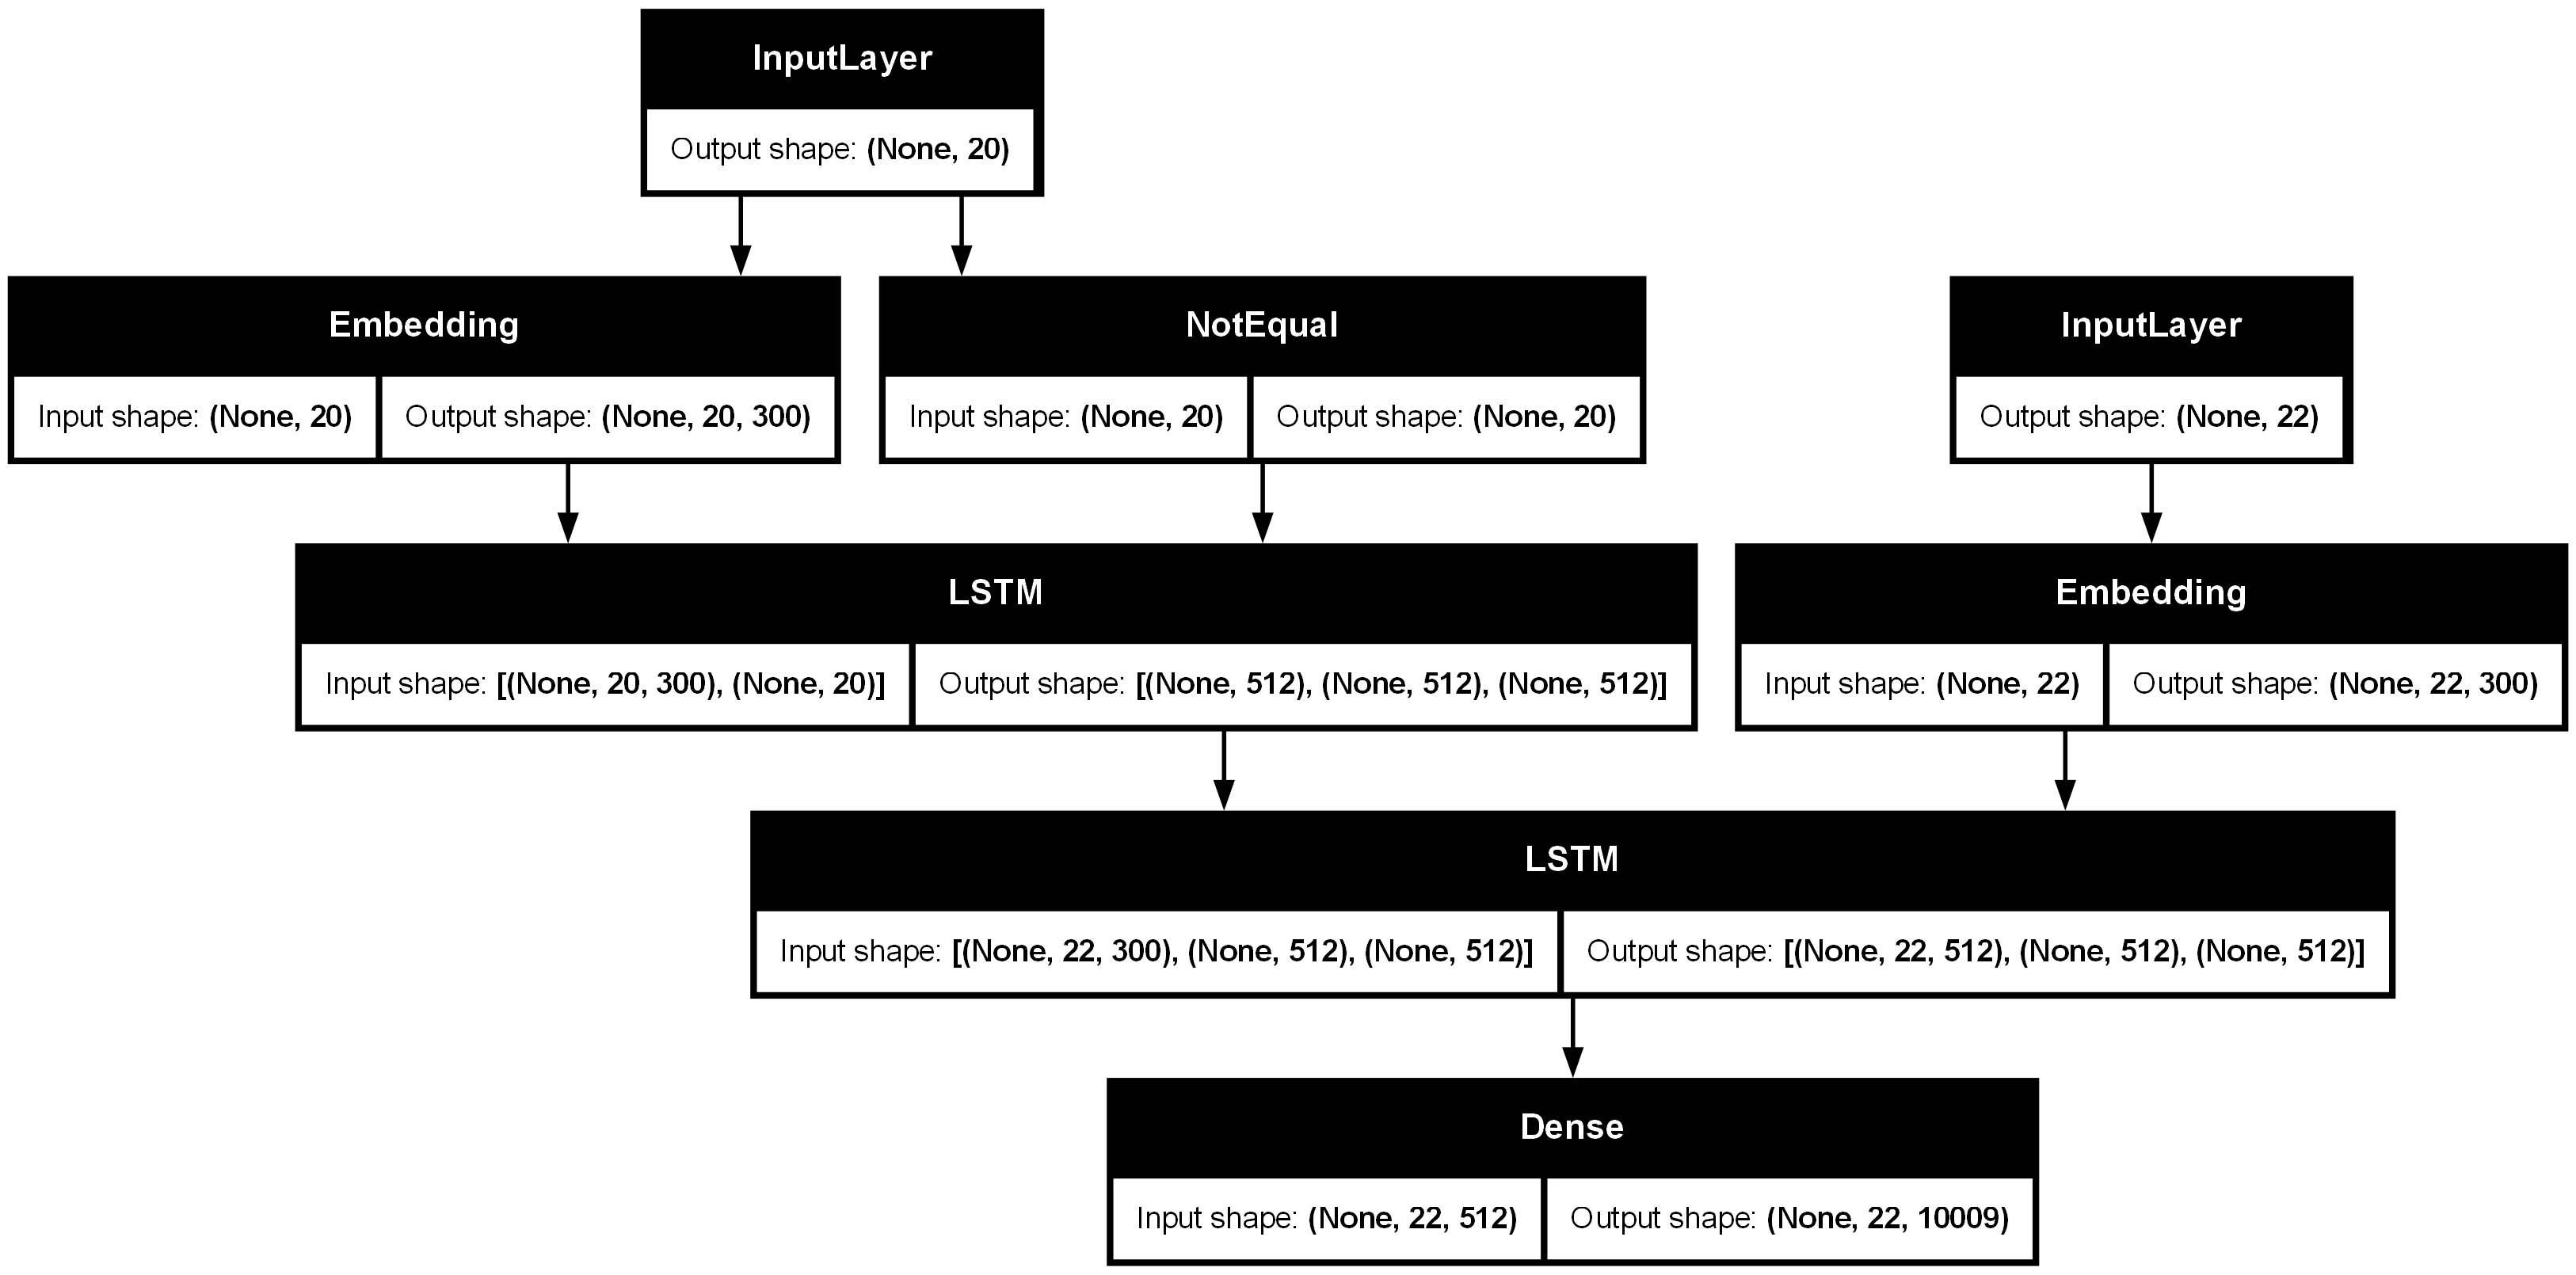

In [40]:
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True)

### 학습

In [ ]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [q_inputs_padded, a_inputs_padded],
    a_targets_padded,
    batch_size=64,
    epochs=70,
    validation_split=0.2
)

Epoch 1/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 57s 365ms/step - accuracy: 0.8184 - loss: 1.8223 - val_accuracy: 0.8041 - val_loss: 1.7829
Epoch 2/70
 34/148 ━━━━━━━━━━━━━━━━━━━━ 36s 318ms/step - accuracy: 0.8379 - loss: 1.3374

In [ ]:
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
decoder_teacher_forcing_model = load_model('decoder_teacher_forcing_model.keras')

# 모델 추론

### 디코더 (추론 모델) 생성

In [ ]:
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))

x = a_embedding_layer(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs_] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │  1,000,900 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[2][0… │
│                     │ (None, 512),      │            │ input_layer_5[0]… │
│                     │ (None, 512)]      │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 10009)  │  5,134,617 │ lstm_1[2][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,390,941 (28.19 MB)

 Trainable params: 7,390,941 (28.19 MB)

 Non-trainable params: 0 (0.00 B)

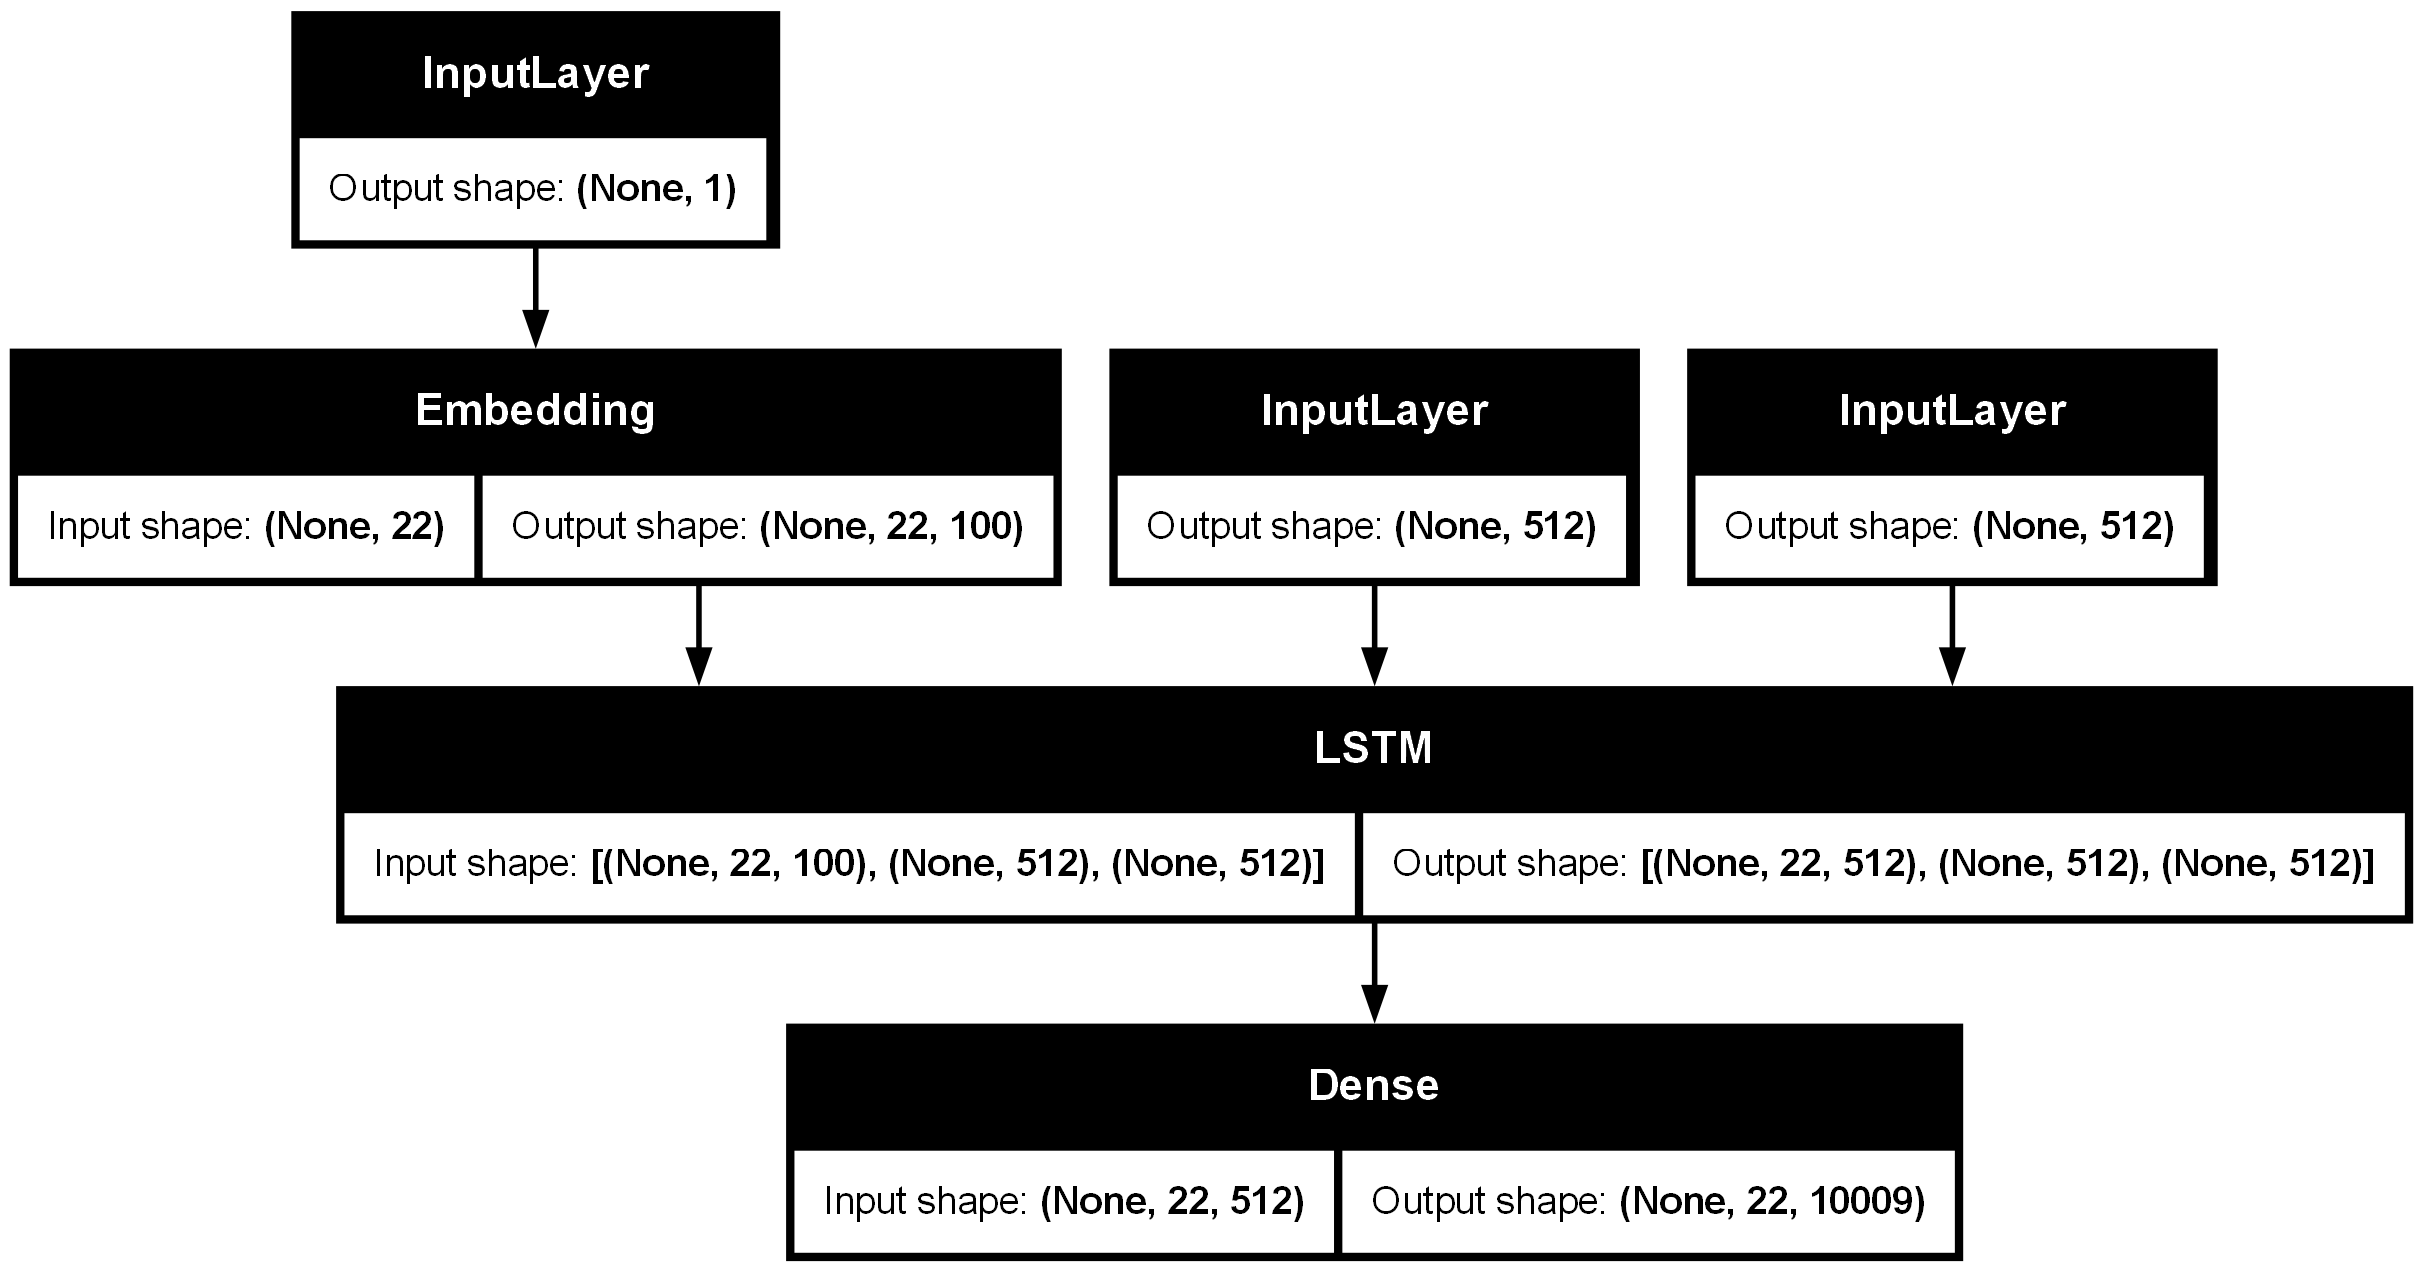

In [ ]:
plot_model(decoder_inference_model, show_shapes=True)

### 추론 함수

In [ ]:
def translate(input_seq):
  encoder_states_value = encoder_model.predict(input_seq)
  decoder_states_value = encoder_states_value

  bos_index = a_tokenizer.word_index['<bos>']
  eos_index = a_tokenizer.word_index['<eos>']

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = bos_index

  output_sentence = []

  for _ in range(a_max_len):
    output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value)

    pred_proba = output_tokens[0, 0, :]
    pred_index = np.argmax(pred_proba)

    if pred_index == eos_index:
      break

    if pred_index > 0:
      word = a_tokenizer.index_word[pred_index]
      output_sentence.append(word)

    target_seq[0, 0] = pred_index
    decoder_states_value = [h, c]

  return " ".join(output_sentence)

### 테스트

In [ ]:
print(Q_inputs[:1])

input_seq = q_inputs_padded[:1]
translate(input_seq)

[['12시 땡!']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'이뤄지지 들어요. 볼 꿰매드릴게요. 끓여드세요. 끓여드세요. 똑똑해도 똑똑해도 숨기는 세상에는 출퇴근하기 잘하면 남이니 않도록 접은 꾸준한 음료 견디셨어요. 함께면 함께면 속아주는 살펴'

# 간단한 chatbot 구현

1. 사용자의 입력을 받아 (처리)
2. 추론 함수에 전달
3. 응답을 출력
4. 1 ~ 3 '종료'전까지 반복

In [ ]:
import math
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ==== 필수 하이퍼파라미터 (학습 때와 동일) ====
q_max_len = 40     # 인코더 입력 최대 길이(학습값과 동일하게!)
# a_max_len은 네가 이미 정의한 값(a_max_len)을 그대로 사용

# ==== (옵션) 형태소 분석을 쓰고 싶으면 True ====
USE_OKT = False

# ==== 안전 전처리 ====
def to_text(x):
    try:
        if x is None: return ""
        if isinstance(x, float) and math.isnan(x): return ""
    except Exception:
        pass
    if isinstance(x, str): return x
    if isinstance(x, (list, tuple)):
        return " ".join(to_text(el) for el in x if el is not None)
    return str(x)

# ==== (옵션) 형태소 분절 ====
okt = None
if USE_OKT:
    try:
        from konlpy.tag import Okt
        okt = Okt()
        print("[INFO] Okt 형태소 분석 사용")
    except Exception as e:
        print(f"[WARN] Okt 로드 실패: {e} -> 공백 기준 처리로 진행")

def preprocess_user_input(s: str) -> str:
    s = to_text(s).strip()
    if okt is not None:
        try:
            s = " ".join(okt.morphs(s, norm=False, stem=False))
        except Exception as e:
            print(f"[WARN] Okt 실패: {e} -> 원문 사용")
    return s

# ==== 소스 문장 → 인코더 입력 텐서 ====
def encode_source(sent: str):
    # 토크나이저로 정수 시퀀스 변환
    seq = q_tokenizer.texts_to_sequences([sent])[0]
    # 학습 시와 동일하게 padding='pre', truncating='pre' 권장(뒤쪽 맥락을 보존)
    enc = pad_sequences([seq], maxlen=q_max_len, padding='pre', truncating='pre')
    return enc

# ==== 네가 준 translate() 함수 그대로 사용 (약간의 방어만 추가) ====
def translate(input_seq):
    # encoder_model: input_seq -> [h, c] (또는 states)
    encoder_states_value = encoder_model.predict(input_seq)

    # LSTM인 경우 보통 [h, c] 리스트 형태. decoder_inference_model 입력 규격에 맞춰 래핑
    if not isinstance(encoder_states_value, list):
        # 단일 텐서가 오는 특수구조라면 모델 정의에 맞게 조정 필요
        encoder_states_value = [encoder_states_value]

    decoder_states_value = encoder_states_value

    bos_index = a_tokenizer.word_index['<bos>']
    eos_index = a_tokenizer.word_index['<eos>']

    # 디코더 입력의 첫 토큰: <bos>
    target_seq = np.zeros((1, 1), dtype='int32')
    target_seq[0, 0] = bos_index

    output_sentence = []

    for _ in range(a_max_len):
        # decoder_inference_model: [target_seq] + decoder_states_value -> (output_tokens, h, c)
        out = decoder_inference_model.predict([target_seq] + decoder_states_value)
        # 출력 분해 (모델 정의에 따라 unpack 방식이 다를 수 있음)
        if isinstance(out, (list, tuple)) and len(out) >= 3:
            output_tokens, h, c = out[0], out[1], out[2]
        else:
            raise RuntimeError(f"decoder_inference_model 출력 형태가 예상과 다릅니다: type={type(out)}, len={len(out) if hasattr(out,'__len__') else 'NA'}")

        # 시점 0의 분포에서 argmax
        pred_proba = output_tokens[0, 0, :]
        pred_index = int(np.argmax(pred_proba))

        # EOS면 종료
        if pred_index == eos_index:
            break

        # PAD(0) 같은 건 스킵 (어휘에 0이 PAD라면)
        if pred_index > 0:
            # index_word가 없을 수 있으니 방어
            idx_word = getattr(a_tokenizer, "index_word", None) or {i:w for w,i in a_tokenizer.word_index.items()}
            word = idx_word.get(pred_index, None)
            if word is not None and word not in ("<bos>", "<eos>", "<pad>", "<OOV>"):
                output_sentence.append(word)

        # 다음 스텝을 위해 현재 예측을 디코더 입력으로
        target_seq[0, 0] = pred_index
        decoder_states_value = [h, c]

    return " ".join(output_sentence)

# ==== REPL 루프 ====
print("✅ 챗봇 준비 완료. 종료하려면 '종료' 또는 'exit/quit' 입력.\n")
while True:
    try:
        user = input("사용자: ").strip()
    except (EOFError, KeyboardInterrupt):
        print("\n[INFO] 종료"); break

    if user == "" or user.lower() in ("quit", "exit") or user == "종료":
        print("[INFO] 종료"); break

    # 1) 전처리
    user_proc = preprocess_user_input(user)
    # 2) 인코더 입력 인코딩/패딩
    enc_in = encode_source(user_proc)
    # 3) 추론
    try:
        reply = translate(enc_in)
    except Exception as e:
        reply = f"[DECODE ERROR] {e}"
    # 4) 출력
    print("봇   :", reply)


✅ 챗봇 준비 완료. 종료하려면 '종료' 또는 'exit/quit' 입력.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
봇   : 이뤄지지 들어요. 볼 꿰매드릴게요. 끓여드세요. 끓여드세요. 똑똑해도 똑똑해도 숨기는 세상에는 출퇴근하기 잘하면 남이니 않도록 접은 꾸준한

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

x = torch.randn(3, 3).to(device)   # GPU로 이동
print(x.device)


Device: cuda
cuda:0
